/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Class Weights: [0.94647205 1.1130186  1.0414994  1.0332005  0.9936143  0.9676617
 0.9099415  0.94647205 1.0942335  0.9228944  0.9328537  1.0672153
 1.0209974  1.076072   0.95343137 1.0414994  1.025033   0.97861636]


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|██████████| 1167/1167 [02:19<00:00,  8.36it/s, loss=1.49]


Epoch 1 - Train Acc: 0.6388, Val Acc: 0.8547, Val Loss: 0.5053
✅ Best model saved.


Training Epoch 2: 100%|██████████| 1167/1167 [02:21<00:00,  8.25it/s, loss=0.604]


Epoch 2 - Train Acc: 0.8595, Val Acc: 0.8513, Val Loss: 0.4604
✅ Best model saved.


Training Epoch 3: 100%|██████████| 1167/1167 [02:20<00:00,  8.31it/s, loss=0.389]


Epoch 3 - Train Acc: 0.8970, Val Acc: 0.8547, Val Loss: 0.4963


Training Epoch 4: 100%|██████████| 1167/1167 [02:20<00:00,  8.32it/s, loss=0.0814]


Epoch 4 - Train Acc: 0.9276, Val Acc: 0.8776, Val Loss: 0.4396
✅ Best model saved.


Training Epoch 5: 100%|██████████| 1167/1167 [02:20<00:00,  8.33it/s, loss=0.0343]


Epoch 5 - Train Acc: 0.9374, Val Acc: 0.8741, Val Loss: 0.4645


Training Epoch 6: 100%|██████████| 1167/1167 [02:20<00:00,  8.33it/s, loss=0.0119]


Epoch 6 - Train Acc: 0.9402, Val Acc: 0.8673, Val Loss: 0.4823
⏹️ Early stopping triggered.


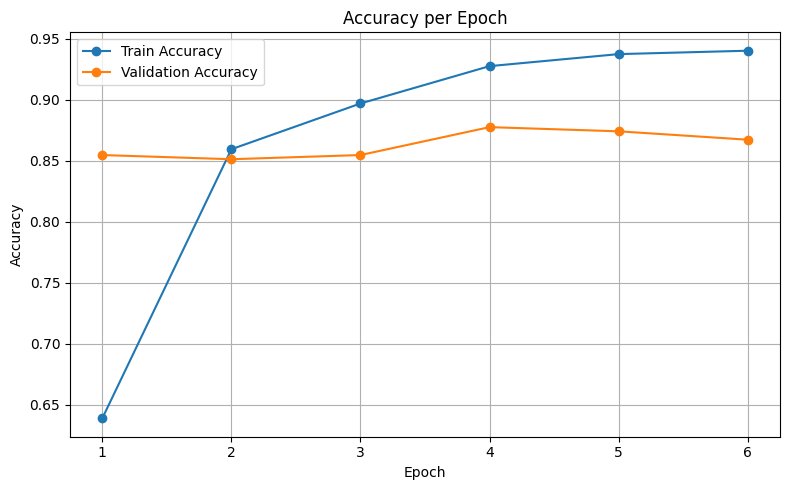

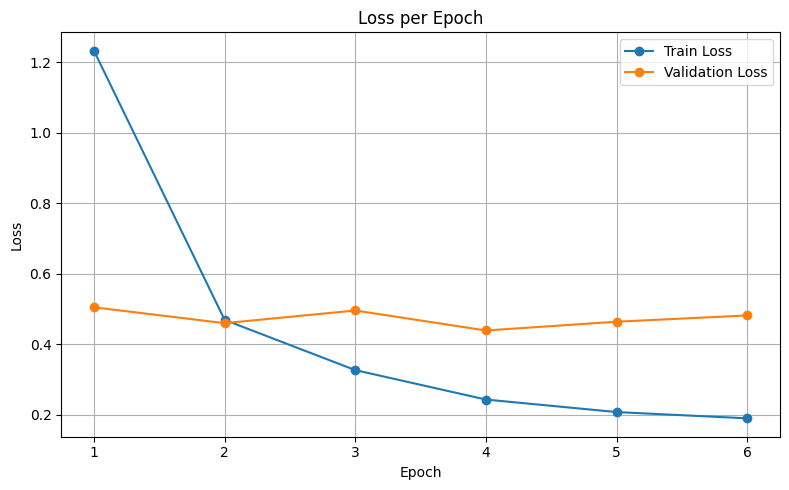

🔄 Best model restored for final evaluation.
Test Loss: 0.5420
Test Report:
              precision    recall  f1-score   support

          AB       0.83      0.91      0.87        93
          AS       0.79      0.83      0.81        82
          DI       0.85      0.61      0.71        95
          DS       0.80      0.78      0.79        89
          ED       0.89      0.90      0.89        97
          EI       0.85      0.85      0.85        95
          EM       0.84      0.77      0.80        92
          ET       1.00      1.00      1.00        96
          FA       0.78      0.78      0.78        89
          IS       0.93      0.95      0.94        95
          MA       0.95      0.82      0.88        95
          NP       0.89      0.80      0.84        90
          PU       1.00      0.98      0.99        91
          SB       0.81      0.81      0.81        91
          SI       0.86      0.97      0.91        91
          SS       0.75      0.95      0.84        95
      

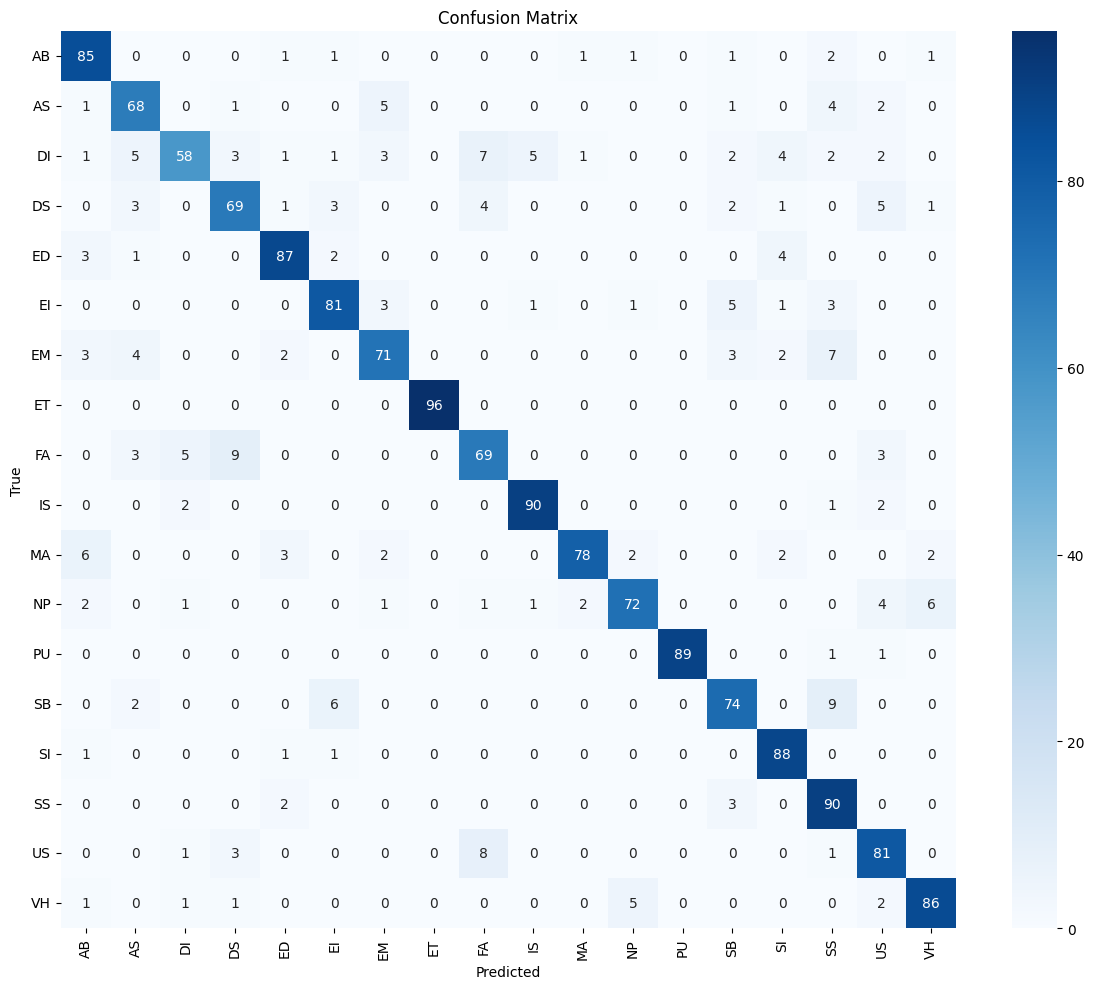

In [1]:
#Learning Rate = 2e-5, Batch Size = 4
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Cihaz kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Veriyi yükle
train_df = pd.read_csv("/content/merged_output_cleaned.csv").dropna(subset=["Sentence", "Stage"])
val_df = pd.read_csv("/content/train_data_cleaned.csv").dropna(subset=["Sentence", "Stage"])
test_df = pd.read_csv("/content/test_data_cleaned.csv").dropna(subset=["Sentence", "Stage"])

# Label encode
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["Stage"])
val_df["label"] = label_encoder.transform(val_df["Stage"])
test_df["label"] = label_encoder.transform(test_df["Stage"])

# Dataset sınıfı
class SchemaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Tokenizer ve veriler
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_dataset = SchemaDataset(train_df["Sentence"].tolist(), train_df["label"].tolist(), tokenizer)
val_dataset = SchemaDataset(val_df["Sentence"].tolist(), val_df["label"].tolist(), tokenizer)
test_dataset = SchemaDataset(test_df["Sentence"].tolist(), test_df["label"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

# Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df["label"]), y=train_df["label"])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights.cpu().numpy())

# Model, optimizer, loss, scheduler
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_encoder.classes_)).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Eğitim döngüsü
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 2

for epoch in range(10):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    train_accuracies.append(train_acc)
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {avg_val_loss:.4f}")
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        early_stop_counter = 0
        print("✅ Best model saved.")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("⏹️ Early stopping triggered.")
            break

# Accuracy Plot
epochs = list(range(1, len(train_accuracies) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_plot_fixed.png", dpi=300)
plt.show()

# Loss Plot
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("loss_plot_fixed.png", dpi=300)
plt.show()

# En iyi modeli geri yükle
model.load_state_dict(torch.load("best_model.pt"))
print("🔄 Best model restored for final evaluation.")

# Test değerlendirme
model.eval()
test_loss, test_preds, true_labels = 0, [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        test_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = np.mean(np.array(test_preds) == np.array(true_labels))
test_f1_macro = f1_score(true_labels, test_preds, average='macro')
test_f1_weighted = f1_score(true_labels, test_preds, average='weighted')

print(f"Test Loss: {avg_test_loss:.4f}")
print("Test Report:")
print(classification_report(true_labels, test_preds, labels=list(range(len(label_encoder.classes_))), target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(true_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ==== SONUÇ KAYDI & ÖZET TABLO ====
results = [{
    "Learning Rate": 2e-5,
    "Batch Size": 4,
    "Train Accuracy (Last Epoch)": train_accuracies[-1],
    "Validation Accuracy (Last Epoch)": val_accuracies[-1],
    "Validation Loss (Last Epoch)": val_losses[-1],
    "Test Accuracy": test_accuracy,
    "Test Loss": avg_test_loss,
    "F1 Score (Macro)": test_f1_macro,
    "F1 Score (Weighted)": test_f1_weighted
}]




In [2]:
# ==== YSQ TEST ====
ysq_df = pd.read_csv("/content/ysq_data_L3.csv").dropna(subset=["Sentence", "Stage"])
ysq_df["label"] = label_encoder.transform(ysq_df["Stage"])
ysq_dataset = SchemaDataset(ysq_df["Sentence"].tolist(), ysq_df["label"].tolist(), tokenizer)
ysq_loader = DataLoader(ysq_dataset, batch_size=4)

model.eval()
ysq_preds, ysq_labels = [], []
with torch.no_grad():
    for batch in ysq_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        ysq_preds.extend(preds.cpu().numpy())
        ysq_labels.extend(labels.cpu().numpy())

ysq_accuracy = np.mean(np.array(ysq_preds) == np.array(ysq_labels))
ysq_f1_macro = f1_score(ysq_labels, ysq_preds, average='macro')
ysq_f1_weighted = f1_score(ysq_labels, ysq_preds, average='weighted')

print("\nYSQ Evaluation:")
print(classification_report(ysq_labels, ysq_preds, labels=list(range(len(label_encoder.classes_))), target_names=label_encoder.classes_))


results[0]["YSQ Accuracy"] = ysq_accuracy
results[0]["YSQ F1 (Macro)"] = ysq_f1_macro
results[0]["YSQ F1 (Weighted)"] = ysq_f1_weighted

results_df = pd.DataFrame(results)
print("\nSummary Table:")
print(results_df)

results_df.to_csv("test1_results_summary.csv", index=False)


YSQ Evaluation:
              precision    recall  f1-score   support

          AB       0.75      0.88      0.81        17
          AS       0.50      0.71      0.59        14
          DI       0.92      0.80      0.86        15
          DS       0.70      0.47      0.56        15
          ED       0.73      0.89      0.80         9
          EI       0.39      0.78      0.52         9
          EM       0.56      1.00      0.71        10
          ET       0.20      0.09      0.12        11
          FA       0.71      0.56      0.62         9
          IS       0.69      0.60      0.64        15
          MA       1.00      0.06      0.11        17
          NP       0.70      0.64      0.67        11
          PU       0.71      0.71      0.71        14
          SB       0.38      0.50      0.43        10
          SI       0.75      0.90      0.82        10
          SS       0.44      0.65      0.52        17
          US       0.81      0.81      0.81        16
          

In [3]:
from sklearn.model_selection import train_test_split

# YSQ verisini oku ve etiketle
ysq_df = pd.read_csv("/content/ysq_data_L3.csv").dropna(subset=["Stage","Sentence"])
ysq_df["label"] = label_encoder.transform(ysq_df["Stage"])

# Train / Validation ayır (stratify önemli!)
train_ysq, val_ysq = train_test_split(
    ysq_df, test_size=0.2, stratify=ysq_df["Stage"], random_state=42
)

# Dataset ve DataLoader
ysq_train_dataset = SchemaDataset(train_ysq["Sentence"].tolist(), train_ysq["label"].tolist(), tokenizer)
ysq_val_dataset = SchemaDataset(val_ysq["Sentence"].tolist(), val_ysq["label"].tolist(), tokenizer)

ysq_train_loader = DataLoader(ysq_train_dataset, batch_size=4, shuffle=True)
ysq_val_loader = DataLoader(ysq_val_dataset, batch_size=4)

# Yeni optimizer ve loss (model zaten bellekte)
optimizer = AdamW(model.parameters(), lr=1e-6)  # küçük öğrenme oranı
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Fine-tuning döngüsü (3 epoch yeterlidir genelde)
print("\n🔁 Starting Fine-Tuning on YSQ Data...\n")
for epoch in range(3):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(enumerate(ysq_train_loader), total=len(ysq_train_loader), desc=f"YSQ Fine-Tune Epoch {epoch+1}")

    for i, batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()
        loop.set_postfix(batch_loss=loss.item(), epoch_loss=total_loss / (i+1))

    train_acc = correct / total
    print(f"Epoch {epoch+1} - YSQ Train Acc: {train_acc:.4f}, Avg Loss: {total_loss / len(ysq_train_loader):.4f}")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in ysq_val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_loss += loss.item()

    val_acc = val_correct / val_total
    print(f"           YSQ Val Acc: {val_acc:.4f}, Val Loss: {val_loss / len(ysq_val_loader):.4f}")



🔁 Starting Fine-Tuning on YSQ Data...



YSQ Fine-Tune Epoch 1: 100%|██████████| 46/46 [00:05<00:00,  7.71it/s, batch_loss=0.245, epoch_loss=1.63]


Epoch 1 - YSQ Train Acc: 0.6304, Avg Loss: 1.6348
           YSQ Val Acc: 0.5745, Val Loss: 1.8427


YSQ Fine-Tune Epoch 2: 100%|██████████| 46/46 [00:05<00:00,  7.92it/s, batch_loss=0.0542, epoch_loss=1.43]


Epoch 2 - YSQ Train Acc: 0.6359, Avg Loss: 1.4268
           YSQ Val Acc: 0.5745, Val Loss: 1.7518


YSQ Fine-Tune Epoch 3: 100%|██████████| 46/46 [00:05<00:00,  7.91it/s, batch_loss=3.06, epoch_loss=1.35]


Epoch 3 - YSQ Train Acc: 0.6685, Avg Loss: 1.3497
           YSQ Val Acc: 0.5957, Val Loss: 1.6850


In [4]:
# ==== YSQ DEĞERLENDİRME ====
ysq_df = pd.read_csv("/content/ysq_data_L3.csv").dropna(subset=["Stage","Sentence"])
ysq_df["label"] = label_encoder.transform(ysq_df["Stage"])

ysq_dataset = SchemaDataset(ysq_df["Sentence"].tolist(), ysq_df["label"].tolist(), tokenizer)
ysq_loader = DataLoader(ysq_dataset, batch_size=4)

model.eval()
ysq_preds, ysq_labels = [], []
with torch.no_grad():
    for batch in ysq_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        ysq_preds.extend(preds.cpu().numpy())
        ysq_labels.extend(labels.cpu().numpy())

ysq_accuracy = np.mean(np.array(ysq_preds) == np.array(ysq_labels))
ysq_f1_macro = f1_score(ysq_labels, ysq_preds, average='macro')
ysq_f1_weighted = f1_score(ysq_labels, ysq_preds, average='weighted')

print("\nYSQ Evaluation:")
print(classification_report(ysq_labels, ysq_preds, labels=list(range(len(label_encoder.classes_))), target_names=label_encoder.classes_))

# YSQ sonuçlarını tabloya ekle
results[0]["YSQ Accuracy"] = ysq_accuracy
results[0]["YSQ F1 (Macro)"] = ysq_f1_macro
results[0]["YSQ F1 (Weighted)"] = ysq_f1_weighted

# Sonuçları tablo olarak yazdır ve kaydet
results_df = pd.DataFrame(results)
print("\nSummary Table:")
print(results_df)




YSQ Evaluation:
              precision    recall  f1-score   support

          AB       0.75      0.88      0.81        17
          AS       0.59      0.71      0.65        14
          DI       0.92      0.80      0.86        15
          DS       0.69      0.60      0.64        15
          ED       0.82      1.00      0.90         9
          EI       0.40      0.89      0.55         9
          EM       0.71      1.00      0.83        10
          ET       0.50      0.09      0.15        11
          FA       0.86      0.67      0.75         9
          IS       0.77      0.67      0.71        15
          MA       1.00      0.12      0.21        17
          NP       0.75      0.82      0.78        11
          PU       0.67      0.86      0.75        14
          SB       0.50      0.50      0.50        10
          SI       0.82      0.90      0.86        10
          SS       0.54      0.76      0.63        17
          US       0.78      0.88      0.82        16
          